<a href="https://colab.research.google.com/github/YasserElmenshawy/detect-covid-from-cough/blob/main/second_model_with_augmantation(use%20resnet%2050).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 54.02 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20210426
20210630
20200803
20210206
20210816
20210507
20201221
20210406
20210914
20200430
20201130
20210523
20200502
20200424
20200901
20210618
20200413
20200824
20210603
20200525
20200919
20200505
20220224
20200820
20201012
20200707
20210830
20201031
20200415
20200419
20200720
20200930
20210714
20200504
20200416
20200814
20210930
20210419
20200417
20200911
20200418
20220116
20200604


In [ ]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-03-26 11:43:49--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  22.7MB/s    in 2m 2s   

2022-03-26 11:45:52 (7.46 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2745/2745 [00:36<00:00, 74.95it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,ycjX7yUM4INKaJYIyQdK8FMSoe22,no_resp_illness_exposed,/content/Coswara-Data/20210426/ycjX7yUM4INKaJY...,0,0,coswara
0,hEj6K9BJ2Ddv8udX3Vw766ns9CB2,healthy,/content/Coswara-Data/20210426/hEj6K9BJ2Ddv8ud...,0,0,coswara
0,Fps26Qa60WYbR5pI15KzNKSeLXG2,positive_asymp,/content/Coswara-Data/20210426/Fps26Qa60WYbR5p...,0,0,coswara
0,Ap3uH6NDwMY5SymZi7OrjaUwiDQ2,resp_illness_not_identified,/content/Coswara-Data/20210426/Ap3uH6NDwMY5Sym...,0,0,coswara
0,atCT4u8oywSbcTkAdFYwrtiVazh2,no_resp_illness_exposed,/content/Coswara-Data/20210426/atCT4u8oywSbcTk...,0,0,coswara


In [ ]:
CosData1['STATUS'].unique()

array(['no_resp_illness_exposed', 'healthy', 'positive_asymp',
       'resp_illness_not_identified', 'positive_mild', 'recovered_full',
       'positive_moderate', 'under_validation'], dtype=object)

In [ ]:
positive_mild = CosData1.loc[CosData1['STATUS']=='positive_mild']
positive_moderate    = CosData1.loc[CosData1['STATUS']=='positive_moderate']
positive_asymp = CosData1.loc[CosData1['STATUS']=='positive_asymp']

positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData1.loc[CosData1['STATUS']=='healthy']
resp_illness_not_identified = CosData1.loc[CosData1['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData1.loc[CosData1['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData1.loc[CosData1['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(positive))
print(len(negative))

f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:1500]
print(len(f_negative))

681
1983
1500


In [ ]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19']

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
## TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,56db4bed-54ee-4560-b962-cbab7d552621,1,1,symptomatic,/content/public_dataset/56db4bed-54ee-4560-b96...,coughvid
1,096f7ce5-56bb-43f7-b57d-dfe303b4ab98,0,0,healthy,/content/public_dataset/096f7ce5-56bb-43f7-b57...,coughvid
2,a934247e-c84a-46eb-95a5-7cc868403633,1,1,healthy,/content/public_dataset/a934247e-c84a-46eb-95a...,coughvid
3,f57ac336-3a78-4571-9a3f-b8beabbb43e7,0,0,healthy,/content/public_dataset/f57ac336-3a78-4571-9a3...,coughvid
4,5683cd42-347e-4fbf-8cd5-aa60c3e5b6cc,1,1,healthy,/content/public_dataset/5683cd42-347e-4fbf-8cd...,coughvid


In [ ]:
covid_TotData = TotData[TotData["STATUS"] == "COVID-19" ]
#symptomatic_TotData = TotData[TotData["STATUS"] == "symptomatic" ][:490]
healthy_TotData = TotData[TotData["STATUS"] != "COVID-19" ][:975]

print(len(covid_TotData) , len(healthy_TotData))
covid_TotData.head()


441 975


,ID,Fever/MP,ORC,STATUS,DIR,DataSet
17,2e9f905a-697c-48db-883e-7e905873172f,0,0,COVID-19,/content/public_dataset/2e9f905a-697c-48db-883...,coughvid
24,e58d45f3-7d6e-48e6-801b-eafc15f1ec85,1,1,COVID-19,/content/public_dataset/e58d45f3-7d6e-48e6-801...,coughvid
32,76779311-1f9c-40b5-845d-bde19b0d9c0e,1,0,COVID-19,/content/public_dataset/76779311-1f9c-40b5-845...,coughvid
33,9c9d5f33-e8e4-4483-a9ba-992fe633e486,1,1,COVID-19,/content/public_dataset/9c9d5f33-e8e4-4483-a9b...,coughvid
35,70450999-745c-43ec-b117-3eefa1b10476,0,0,COVID-19,/content/public_dataset/70450999-745c-43ec-b11...,coughvid


In [ ]:
#!pip install audiomentations
!pip install audiomentations


     |████████████████████████████████| 67 kB 2.3 MB/s 


In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa
print(len(covid_TotData))
print(len(positive))

441
681


In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

os.makedirs("augmented_data_coswara")


In [ ]:
#os.makedirs("augmented_data_coswara")

xx = pd.DataFrame()

for audio_file in  tqdm(positive["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav", augmented_sample, sr) #write with wav extantion

    xx = xx.append(positive.loc[positive['ID'] == audio_file.split("/")[-2]])
    xx["DIR"].replace({ audio_file : "/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav"}, inplace=True)
    xx["ID"].replace({ audio_file.split("/")[-2] :  audio_file.split("/")[-2] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

 46%|████▋     | 316/681 [02:01<01:45,  3.47it/s]


 File Not Found :))


 73%|███████▎  | 499/681 [03:12<00:54,  3.31it/s]


 File Not Found :))


 93%|█████████▎| 630/681 [04:07<00:18,  2.73it/s]


 File Not Found :))


100%|██████████| 681/681 [04:23<00:00,  2.58it/s]


In [ ]:
os.makedirs("augmented_data_coughvid")

yy = pd.DataFrame()

for audio_file in  tqdm(covid_TotData["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion

    yy = yy.append(covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]])
    yy["DIR"].replace({"/content/augmented_data_coughvid/"+ audio_file.split("/")[-1][0:-5] + ".webm": "/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav"}, inplace=True)
    yy["ID"].replace({ audio_file.split("/")[-1][0:-5] :  audio_file.split("/")[-1][0:-5] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

  0%|          | 0/441 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/441 [00:02<15:55,  2.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/441 [00:03<10:35,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/441 [00:03<08:26,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/441 [00:04<06:37,  1.10it/s]/usr/local/li


 File Not Found :))


  5%|▌         | 24/441 [00:22<05:00,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 25/441 [00:23<05:14,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 26/441 [00:24<05:14,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 27/441 [00:25<05:50,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 28/441 [00:26<05:43,  1.20it/s]


 File Not Found :))


 29%|██▉       | 127/441 [02:00<04:09,  1.26it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 128/441 [02:01<04:44,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 129/441 [02:02<05:13,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 130/441 [02:03<05:18,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 131/441 [02:04<05:27,  1.05


 File Not Found :))


 39%|███▊      | 170/441 [02:40<03:53,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 171/441 [02:41<03:46,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 172/441 [02:42<03:52,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 173/441 [02:43<03:52,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 174/441 [02:44<04:10,  1.06


 File Not Found :))


 47%|████▋     | 209/441 [03:14<02:55,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 210/441 [03:15<03:22,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 211/441 [03:16<03:40,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 212/441 [03:17<03:48,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 213/441 [03:18<03:41,  1.03


 File Not Found :))


 62%|██████▏   | 275/441 [04:13<02:01,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 276/441 [04:14<02:21,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 277/441 [04:15<02:24,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 278/441 [04:16<02:35,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 279/441 [04:17<02:45,  1.02


 File Not Found :))


 86%|████████▌ | 378/441 [05:45<00:56,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 379/441 [05:47<00:59,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 380/441 [05:47<00:55,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▋ | 381/441 [05:48<00:59,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 382/441 [05:49<00:57,  1.03


 File Not Found :))


 96%|█████████▌| 424/441 [06:29<00:13,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▋| 425/441 [06:29<00:10,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 426/441 [06:31<00:12,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 427/441 [06:32<00:12,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 428/441 [06:33<00:12,  1.02

In [ ]:
covid_TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
4,015ec831-e765-44ee-aefc-10dfd95dec78,1,1,COVID-19,/content/public_dataset/015ec831-e765-44ee-aef...,coughvid
12,583240d0-4e6f-4456-8894-be5a74010add,1,1,COVID-19,/content/public_dataset/583240d0-4e6f-4456-889...,coughvid
21,d5e56f55-97a1-417d-a724-04d6ef10830e,0,0,COVID-19,/content/public_dataset/d5e56f55-97a1-417d-a72...,coughvid
23,f18097f1-d7d5-4566-a7f1-dce0f2e8da87,0,0,COVID-19,/content/public_dataset/f18097f1-d7d5-4566-a7f...,coughvid
26,b05935c3-68d7-4a28-aea9-f92fbe295c6c,0,0,COVID-19,/content/public_dataset/b05935c3-68d7-4a28-aea...,coughvid


In [ ]:
healthy_TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,d41862aa-02cc-485f-98cf-11a9196e74d2,1,1,healthy,/content/public_dataset/d41862aa-02cc-485f-98c...,coughvid
1,73fc1cdd-e291-46f7-9353-4a7b93cd08de,0,1,symptomatic,/content/public_dataset/73fc1cdd-e291-46f7-935...,coughvid
2,bb6cdd96-eca0-40a3-a450-c367d5489711,0,1,healthy,/content/public_dataset/bb6cdd96-eca0-40a3-a45...,coughvid
3,b3456373-4c8f-4482-aa0a-455fc9e13c52,0,0,healthy,/content/public_dataset/b3456373-4c8f-4482-aa0...,coughvid
4,ccb1c1a0-4598-4acf-958d-a9fc1e8a6196,0,0,healthy,/content/public_dataset/ccb1c1a0-4598-4acf-958...,coughvid


In [ ]:
yy.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
12,178f39e2-a261-4ec6-a8fb-3f89c3c795bbAUG,0,1,COVID-19,/content/public_dataset/178f39e2-a261-4ec6-a8f...,coughvid
22,56ecb826-b12c-43d9-b54b-8dedede30b0fAUG,0,0,COVID-19,/content/public_dataset/56ecb826-b12c-43d9-b54...,coughvid
30,c5f4b9fe-04cd-441b-801f-ae24db6b2fc7AUG,0,0,COVID-19,/content/public_dataset/c5f4b9fe-04cd-441b-801...,coughvid
31,e4ec845a-b80b-409b-afa0-81abc3ae3dc7AUG,0,0,COVID-19,/content/public_dataset/e4ec845a-b80b-409b-afa...,coughvid
41,c91f755a-e37e-4106-a90a-bb0672fdfd24AUG,1,0,COVID-19,/content/public_dataset/c91f755a-e37e-4106-a90...,coughvid


In [ ]:
xx.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,EUjlCZyR0xMbOH31Je8knI3UdKO2AUG,positive_mild,/content/augmented_data_coswara/EUjlCZyR0xMbOH...,0,0,coswara
0,QFxGVP17oxZUKUsuaW0O32qFdoT2AUG,positive_mild,/content/augmented_data_coswara/QFxGVP17oxZUKU...,0,0,coswara
0,d6tJkKV7x1TFBe8WNnLhvLuoXgd2AUG,positive_mild,/content/augmented_data_coswara/d6tJkKV7x1TFBe...,1,1,coswara
0,LasObOSE2kQYWhWkA7WimXxhwUE2AUG,positive_mild,/content/augmented_data_coswara/LasObOSE2kQYWh...,1,0,coswara
0,Y7RB11Ha8VNbBDjGoYVuIxnpYKA2AUG,positive_mild,/content/augmented_data_coswara/Y7RB11Ha8VNbBD...,0,0,coswara


In [ ]:
positive.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,EUjlCZyR0xMbOH31Je8knI3UdKO2,positive_mild,/content/Coswara-Data/20210426/EUjlCZyR0xMbOH3...,0,0,coswara
0,QFxGVP17oxZUKUsuaW0O32qFdoT2,positive_mild,/content/Coswara-Data/20210426/QFxGVP17oxZUKUs...,0,0,coswara
0,d6tJkKV7x1TFBe8WNnLhvLuoXgd2,positive_mild,/content/Coswara-Data/20210426/d6tJkKV7x1TFBe8...,1,1,coswara
0,LasObOSE2kQYWhWkA7WimXxhwUE2,positive_mild,/content/Coswara-Data/20210426/LasObOSE2kQYWhW...,1,0,coswara
0,Y7RB11Ha8VNbBDjGoYVuIxnpYKA2,positive_mild,/content/Coswara-Data/20210426/Y7RB11Ha8VNbBDj...,0,0,coswara


In [ ]:
f_negative.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,hEj6K9BJ2Ddv8udX3Vw766ns9CB2,healthy,/content/Coswara-Data/20210426/hEj6K9BJ2Ddv8ud...,0,0,coswara
0,A3uqqSyxT5MpzFwc0dCpiYRV4w53,healthy,/content/Coswara-Data/20210426/A3uqqSyxT5MpzFw...,0,0,coswara
0,CpB4mhP3leTMxJdDG3cD3xMN2AI3,healthy,/content/Coswara-Data/20210426/CpB4mhP3leTMxJd...,0,0,coswara
0,qndmFcdekodLGpiKxKMVQlrJfcp2,healthy,/content/Coswara-Data/20210426/qndmFcdekodLGpi...,0,0,coswara
0,l6xp4FcV20QYTrj0uF0GkKnXY1x2,healthy,/content/Coswara-Data/20210426/l6xp4FcV20QYTrj...,0,0,coswara


## creat datamerge to put all data in thet

In [ ]:
datamerge = pd.concat([covid_TotData,healthy_TotData,yy,xx,positive,f_negative])

In [ ]:
print(len(datamerge))

4709


In [ ]:
def feature_extractor(row):

  name     = row[-6]
  try:
    audio,sr = librosa.load(row[-2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=22050, n_mfcc=13)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
   # return mfccsscaled

  return mfccsscaled,savepath



In [ ]:

features = []
diagnoses= []
imgpaths = []

# train
for row in tqdm(datamerge.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[-5],row[-4]])


  0%|          | 0/4709 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/4709 [00:01<1:25:56,  1.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/4709 [00:02<1:25:19,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/4709 [00:03<1:25:00,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/4709 [00:04<1:15:30,  1.04it/s]

File cannot open


  1%|          | 24/4709 [00:23<1:04:21,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 25/4709 [00:24<1:04:30,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 26/4709 [00:25<1:09:02,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 27/4709 [00:26<1:12:46,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 28/4709 [00:27<1:16

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 127/4709 [02:06<1:07:58,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 128/4709 [02:07<1:12:42,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 129/4709 [02:08<1:16:34,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 130/4709 [02:09<1:17:46,  1.02s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 170/4709 [02:51<1:12:06,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 171/4709 [02:52<1:17:25,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 172/4709 [02:53<1:20:00,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 173/4709 [02:54<1:21:25,  1.08s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 209/4709 [03:31<1:10:47,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 210/4709 [03:32<1:13:39,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 211/4709 [03:33<1:16:36,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 212/4709 [03:34<1:17:00,  1.03s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 275/4709 [04:48<2:00:12,  1.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 276/4709 [04:50<2:12:37,  1.80s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 277/4709 [04:52<2:15:47,  1.84s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 278/4709 [04:54<2:16:04,  1.84s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 378/4709 [06:48<1:17:36,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 379/4709 [06:50<1:21:45,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 380/4709 [06:51<1:24:49,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 381/4709 [06:52<1:27:22,  1.21s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 424/4709 [07:43<1:13:46,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 425/4709 [07:44<1:08:42,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 426/4709 [07:45<1:16:12,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 427/4709 [07:47<1:26:04,  1.21s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 475/4709 [08:45<1:18:51,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 476/4709 [08:46<1:15:04,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 477/4709 [08:48<1:16:26,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 478/4709 [08:49<1:22:39,  1.17s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 480/4709 [08:50<1:08:48,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 481/4709 [08:52<1:17:01,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 482/4709 [08:53<1:22:38,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 483/4709 [08:54<1:25:50,  1.22s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 526/4709 [09:49<1:18:27,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 527/4709 [09:50<1:23:44,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 528/4709 [09:51<1:27:22,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 529/4709 [09:53<1:24:22,  1.21s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 584/4709 [11:06<1:26:59,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 585/4709 [11:07<1:24:29,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 586/4709 [11:08<1:30:35,  1.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 587/4709 [11:10<1:32:37,  1.35s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 589/4709 [11:11<1:12:51,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 590/4709 [11:13<1:21:26,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 591/4709 [11:14<1:18:31,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 592/4709 [11:15<1:25:31,  1.25s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 597/4709 [11:21<1:14:58,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 598/4709 [11:22<1:22:21,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 599/4709 [11:24<1:21:59,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 600/4709 [11:25<1:26:54,  1.27s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 669/4709 [13:01<1:25:44,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 670/4709 [13:03<1:31:16,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 671/4709 [13:04<1:28:56,  1.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 672/4709 [13:06<1:33:40,  1.39s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 685/4709 [13:24<1:26:24,  1.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 686/4709 [13:24<1:12:20,  1.08s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 687/4709 [13:26<1:22:48,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 688/4709 [13:27<1:23:31,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 689/4709 [13:28<1:24:14,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 690/4709 [13:30<1:30:05,  1.35s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 707/4709 [13:53<1:24:45,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 708/4709 [13:55<1:29:33,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 709/4709 [13:56<1:32:20,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 710/4709 [13:58<1:36:02,  1.44s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 740/4709 [14:43<1:33:25,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 741/4709 [14:44<1:29:37,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 742/4709 [14:45<1:14:13,  1.12s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 743/4709 [14:46<1:24:09,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 744/4709 [14:48<1:32:03,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 745/4709 [14:50<1:35:24,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 746/4709 [14:51<1:37:40,  1.48s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 759/4709 [15:15<2:19:12,  2.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 760/4709 [15:17<2:24:03,  2.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 761/4709 [15:19<2:17:16,  2.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 762/4709 [15:21<2:09:47,  1.97s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 779/4709 [15:45<1:29:44,  1.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 780/4709 [15:47<1:35:11,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 781/4709 [15:49<1:37:12,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 782/4709 [15:50<1:38:47,  1.51s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 831/4709 [17:04<1:29:05,  1.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 832/4709 [17:05<1:34:03,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 833/4709 [17:07<1:37:00,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 834/4709 [17:08<1:33:06,  1.44s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 964/4709 [20:35<1:31:09,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 965/4709 [20:37<1:36:01,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 966/4709 [20:38<1:38:18,  1.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 967/4709 [20:40<1:40:16,  1.61s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1014/4709 [21:56<1:31:19,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1015/4709 [21:58<1:34:10,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1016/4709 [21:59<1:38:43,  1.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1017/4709 [22:01<1:34:40,  1.54s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1045/4709 [22:47<1:31:51,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1046/4709 [22:48<1:30:27,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1047/4709 [22:50<1:34:05,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1048/4709 [22:52<1:38:13,  1.61s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1062/4709 [23:15<1:32:52,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1063/4709 [23:16<1:34:10,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1064/4709 [23:18<1:39:00,  1.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1065/4709 [23:19<1:37:40,  1.61s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 1111/4709 [24:36<1:25:07,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 1112/4709 [24:38<1:32:35,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 1113/4709 [24:40<1:37:35,  1.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 1114/4709 [24:41<1:40:11,  1.67s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1232/4709 [28:12<1:13:56,  1.28s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1233/4709 [28:13<1:23:36,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1234/4709 [28:15<1:24:55,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1235/4709 [28:16<1:25:48,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1236/4709 [28:18<1:29:27,  1.55s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1351/4709 [31:45<1:33:37,  1.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1352/4709 [31:47<1:38:17,  1.76s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1353/4709 [31:49<1:42:59,  1.84s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1354/4709 [31:51<1:39:55,  1.79s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1370/4709 [32:19<1:32:36,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1371/4709 [32:21<1:36:54,  1.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1372/4709 [32:23<1:40:43,  1.81s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1373/4709 [32:25<1:42:42,  1.85s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1392/4709 [33:00<1:28:56,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1393/4709 [33:02<1:34:33,  1.71s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1394/4709 [33:03<1:36:06,  1.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1395/4709 [33:05<1:33:21,  1.69s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1415/4709 [33:42<1:30:49,  1.65s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1416/4709 [33:44<1:33:04,  1.70s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1417/4709 [33:46<1:38:18,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1418/4709 [33:48<1:41:39,  1.85s/it]/usr/local/lib/python3.7/dis

File cannot open


 64%|██████▍   | 3027/4709 [55:19<10:10,  2.75it/s]

File cannot open


 67%|██████▋   | 3158/4709 [56:21<12:27,  2.07it/s]

File cannot open


 69%|██████▉   | 3249/4709 [57:00<13:53,  1.75it/s]

File cannot open


 70%|██████▉   | 3281/4709 [57:15<09:37,  2.47it/s]

File cannot open


 70%|███████   | 3309/4709 [57:28<11:54,  1.96it/s]

File cannot open


 73%|███████▎  | 3439/4709 [58:29<10:33,  2.00it/s]

File cannot open


 74%|███████▍  | 3473/4709 [58:46<09:32,  2.16it/s]

File cannot open


 74%|███████▍  | 3484/4709 [58:51<11:07,  1.84it/s]

File cannot open


 75%|███████▍  | 3511/4709 [59:06<12:59,  1.54it/s]

File cannot open


 77%|███████▋  | 3643/4709 [1:00:09<08:29,  2.09it/s]

File cannot open


 79%|███████▉  | 3728/4709 [1:00:55<06:29,  2.52it/s]

File cannot open


 80%|███████▉  | 3758/4709 [1:01:08<11:55,  1.33it/s]

File cannot open


 80%|████████  | 3789/4709 [1:01:20<04:10,  3.67it/s]

File cannot open


 80%|████████  | 3790/4709 [1:01:21<04:40,  3.28it/s]

File cannot open


 84%|████████▍ | 3976/4709 [1:02:47<07:11,  1.70it/s]

File cannot open


 85%|████████▌ | 4021/4709 [1:03:12<06:52,  1.67it/s]

File cannot open


 88%|████████▊ | 4160/4709 [1:04:26<04:58,  1.84it/s]

File cannot open


 89%|████████▊ | 4177/4709 [1:04:35<04:22,  2.03it/s]

File cannot open


 91%|█████████ | 4266/4709 [1:05:18<02:51,  2.59it/s]

File cannot open


 91%|█████████ | 4270/4709 [1:05:19<02:18,  3.16it/s]

File cannot open


 91%|█████████ | 4280/4709 [1:05:23<03:29,  2.05it/s]

File cannot open


 91%|█████████▏| 4305/4709 [1:05:36<03:36,  1.87it/s]

File cannot open


 92%|█████████▏| 4319/4709 [1:05:41<02:55,  2.22it/s]

File cannot open


 92%|█████████▏| 4338/4709 [1:05:50<02:58,  2.08it/s]

File cannot open


 93%|█████████▎| 4357/4709 [1:05:59<03:18,  1.77it/s]

File cannot open


 93%|█████████▎| 4363/4709 [1:06:01<02:55,  1.97it/s]

File cannot open


 93%|█████████▎| 4374/4709 [1:06:07<02:50,  1.97it/s]

File cannot open


 97%|█████████▋| 4553/4709 [1:07:35<01:03,  2.46it/s]

File cannot open


 98%|█████████▊| 4593/4709 [1:07:55<01:03,  1.82it/s]

File cannot open


 98%|█████████▊| 4617/4709 [1:08:04<00:37,  2.46it/s]

File cannot open


 99%|█████████▊| 4642/4709 [1:08:15<00:32,  2.09it/s]

File cannot open


100%|█████████▉| 4687/4709 [1:08:44<00:07,  2.75it/s]

File cannot open


100%|██████████| 4709/4709 [1:08:54<00:00,  1.14it/s]


In [ ]:
isnone = lambda x: x is not None
label  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x = list(map(isnone,features))
data_y = list(map(label,datamerge['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx = [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp = [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

In [ ]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 1
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [ ]:
print(len(DATA[0]['MFCCS']))

4643


In [ ]:
import pickle

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=32,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 32
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch,X1_batch,X2_batch, X3_batch]
      return X_batch, Y_batch

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [ ]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=13)
  lay1   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = BatchNormalization()(lay1)
  lay3   = Dropout(0.5)(lay2)
  lay4   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay5   = BatchNormalization()(lay4)
  lay6   = Dropout(0.5)(lay5)

  #first +1 model
  inp11   = Input(shape=13)
  lay11   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay21   = BatchNormalization()(lay1)
  lay31   = Dropout(0.5)(lay2)
  lay41   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay51   = BatchNormalization()(lay4)
  lay61   = Dropout(0.5)(lay5)

  # first merge input models
  merge1 = concatenate([lay6,lay61])

# resnet
  inp2   = ResNet50(weights='imagenet', include_top=False)
  x = inp2.output

#first branch 
  x11 = GlobalAveragePooling2D()(x)
  x21   = BatchNormalization()(x11)
  x31   = Dropout(0.5)(x21)

#second branch
  x12 = GlobalAveragePooling2D()(x)
  x22   = BatchNormalization()(x12)
  x32   = Dropout(0.5)(x22)

#merge resnet 
  mergeXX = concatenate([x31,x32])
  x13   = BatchNormalization()(mergeXX)
  x23   = Dropout(0.5)(x13)


  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=5,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = BatchNormalization()(lay31)
  lay33  = Dropout(0.5)(lay32)
  lay34  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay33)
  lay35  = BatchNormalization()(lay34)
  lay36  = Dropout(0.5)(lay35)

 # second merge input models
  merge2 = concatenate([merge1,lay36])

  # merge input models
  merge3 = concatenate([x23, merge2])

  # interpretation model
  hidden1 = Dense(256, activation='relu')(merge3)
  hidden2  = BatchNormalization()(hidden1)
  hidden3  = Dropout(0.5)(hidden2)
  output  = Dense(1, activation='sigmoid')(hidden3)
  MERGM   = Model(inputs=[inp1,inp11 ,inp2.input,inp3], outputs=output)
  
  for layer in inp2.layers:
    layer.trainable = False


  return MERGM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6708802620017573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6499247214694369
116/116 - 461s - loss: 0.8459 - auc: 0.6897 - val_loss: 0.6636 - val_auc: 0.6707 - 461s/epoch - 4s/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8175373432382778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7654120244906153
116/116 - 459s - loss: 0.6665 - auc: 0.7458 - val_loss: 0.5670 - val_auc: 0.8172 - 459s/epoch - 4s/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8288801022445882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7886781090033121
116/116 - 453s - loss: 0.6020 - auc: 0.7696 - val_loss: 0.5174 - val_auc: 0.8289 - 453s/epoch - 4s/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8293194344596214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8046572317575027
116/116 - 450s - loss: 0.5592 - auc: 0.7911 - val_loss: 0.5170 - val_auc: 0.8293 - 450s/epoch - 4s/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8277018931224538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8118036735922916
116/116 - 449s - loss: 0.5442 - auc: 0.7992 - val_loss: 0.5158 - val_auc: 0.8275 - 449s/epoch - 4s/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8369478392842877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8181471444344073
116/116 - 450s - loss: 0.5239 - auc: 0.8163 - val_loss: 0.5017 - val_auc: 0.8371 - 450s/epoch - 4s/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8337327262560907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8190304125263475
116/116 - 448s - loss: 0.5241 - auc: 0.8121 - val_loss: 0.5053 - val_auc: 0.8334 - 448s/epoch - 4s/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8382258966371116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8222623707718559
116/116 - 450s - loss: 0.5109 - auc: 0.8246 - val_loss: 0.5110 - val_auc: 0.8379 - 450s/epoch - 4s/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8343517852863648


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8238080899327512
116/116 - 451s - loss: 0.5024 - auc: 0.8303 - val_loss: 0.5014 - val_auc: 0.8341 - 451s/epoch - 4s/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8435977314481988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8306333433704708
116/116 - 445s - loss: 0.5071 - auc: 0.8283 - val_loss: 0.4944 - val_auc: 0.8434 - 445s/epoch - 4s/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8408618899273105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8224028906955736
116/116 - 447s - loss: 0.4975 - auc: 0.8353 - val_loss: 0.4998 - val_auc: 0.8409 - 447s/epoch - 4s/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8429786724179249


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8241895011542708
116/116 - 446s - loss: 0.4987 - auc: 0.8324 - val_loss: 0.5101 - val_auc: 0.8429 - 446s/epoch - 4s/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8479511143062545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8311753487905249
116/116 - 447s - loss: 0.5010 - auc: 0.8311 - val_loss: 0.4922 - val_auc: 0.8482 - 447s/epoch - 4s/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8402628005431744


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8207568001605942
116/116 - 443s - loss: 0.4839 - auc: 0.8418 - val_loss: 0.4990 - val_auc: 0.8403 - 443s/epoch - 4s/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.838325744867801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8293887383318278
116/116 - 447s - loss: 0.4806 - auc: 0.8468 - val_loss: 0.4906 - val_auc: 0.8382 - 447s/epoch - 4s/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8453350906621935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8284050988658034
116/116 - 445s - loss: 0.4862 - auc: 0.8416 - val_loss: 0.4958 - val_auc: 0.8454 - 445s/epoch - 4s/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.845255212077642


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.833062330623306
116/116 - 448s - loss: 0.4849 - auc: 0.8414 - val_loss: 0.4952 - val_auc: 0.8451 - 448s/epoch - 4s/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8481508107676331


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8298705209274315
116/116 - 448s - loss: 0.4780 - auc: 0.8488 - val_loss: 0.4878 - val_auc: 0.8479 - 448s/epoch - 4s/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8488697180285965


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8309746060423567
116/116 - 455s - loss: 0.4836 - auc: 0.8431 - val_loss: 0.4997 - val_auc: 0.8488 - 455s/epoch - 4s/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8409018292195863


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8245909866506074
116/116 - 459s - loss: 0.4741 - auc: 0.8523 - val_loss: 0.5053 - val_auc: 0.8409 - 459s/epoch - 4s/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


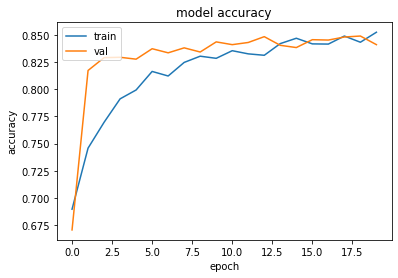

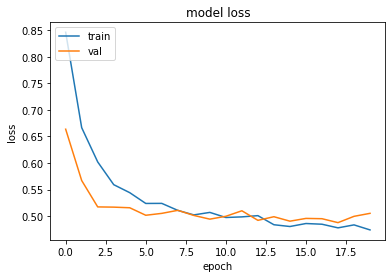

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5074231028556824 , AUC = 0.8246712684631348 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8409018292195863
test 0.8245909866506074

-----------------------------------------------------------------


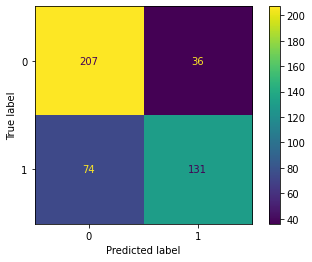

In [35]:
# Create directory to save models
import matplotlib.pyplot as plt

rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  #optimizer = keras.optimizers.Adam(lr=0.01)

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  

  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

0
Num_samples: 448
acc:  0.7544642857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


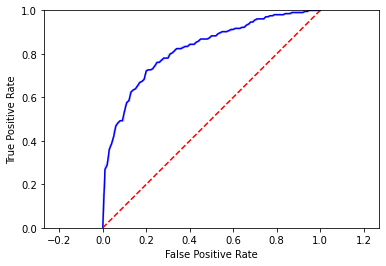

In [36]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/020--0.505--0.474.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(224,224))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

## 50 epoch


rm: cannot remove '/content/models/50epoch': No such file or directory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5981508107676332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.673170731707317
116/116 - 488s - loss: 0.8344 - auc: 0.7028 - val_loss: 0.7065 - val_auc: 0.5986 - 488s/epoch - 4s/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.779894560268392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7549734015858678
116/116 - 459s - loss: 0.6894 - auc: 0.7318 - val_loss: 0.6947 - val_auc: 0.7805 - 459s/epoch - 4s/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8069933700774823


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7800863193817122
116/116 - 449s - loss: 0.6261 - auc: 0.7466 - val_loss: 0.5905 - val_auc: 0.8066 - 449s/epoch - 4s/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8155403786244908


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7927933353407608
116/116 - 450s - loss: 0.5708 - auc: 0.7813 - val_loss: 0.5807 - val_auc: 0.8159 - 450s/epoch - 4s/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8232486620337087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8062832480176653
116/116 - 450s - loss: 0.5574 - auc: 0.7848 - val_loss: 0.5395 - val_auc: 0.8233 - 450s/epoch - 4s/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.835829539100567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8119441935160091
116/116 - 453s - loss: 0.5409 - auc: 0.8009 - val_loss: 0.5138 - val_auc: 0.8359 - 453s/epoch - 4s/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8363287802540138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8176051390143532
116/116 - 449s - loss: 0.5365 - auc: 0.8021 - val_loss: 0.5026 - val_auc: 0.8366 - 449s/epoch - 4s/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8220105439731606


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8177456589380708
116/116 - 449s - loss: 0.5195 - auc: 0.8160 - val_loss: 0.5193 - val_auc: 0.8221 - 449s/epoch - 4s/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8278816199376946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8163806082505268
116/116 - 454s - loss: 0.5263 - auc: 0.8102 - val_loss: 0.5090 - val_auc: 0.8281 - 454s/epoch - 4s/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8283209521527279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8222824450466728
116/116 - 455s - loss: 0.5052 - auc: 0.8260 - val_loss: 0.5052 - val_auc: 0.8288 - 455s/epoch - 4s/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8330138189951274


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8257552945899829
116/116 - 464s - loss: 0.4996 - auc: 0.8315 - val_loss: 0.5186 - val_auc: 0.8327 - 464s/epoch - 4s/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8360492052080839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.821680216802168
116/116 - 419s - loss: 0.5057 - auc: 0.8254 - val_loss: 0.5187 - val_auc: 0.8360 - 419s/epoch - 4s/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8361490534387732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8232259359630634
116/116 - 424s - loss: 0.5062 - auc: 0.8233 - val_loss: 0.5004 - val_auc: 0.8360 - 424s/epoch - 4s/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8113267832894001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8022282445046672
116/116 - 423s - loss: 0.4931 - auc: 0.8380 - val_loss: 0.5256 - val_auc: 0.8113 - 423s/epoch - 4s/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8333333333333333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8129278329820335
116/116 - 422s - loss: 0.5002 - auc: 0.8325 - val_loss: 0.4993 - val_auc: 0.8332 - 422s/epoch - 4s/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8388649253135234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.824169426879454
116/116 - 437s - loss: 0.5013 - auc: 0.8281 - val_loss: 0.5019 - val_auc: 0.8392 - 437s/epoch - 4s/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8372473839763559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8228846732911774
116/116 - 431s - loss: 0.4891 - auc: 0.8387 - val_loss: 0.5107 - val_auc: 0.8374 - 431s/epoch - 4s/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.826903107276939


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8154170430593195
116/116 - 442s - loss: 0.4877 - auc: 0.8383 - val_loss: 0.5157 - val_auc: 0.8271 - 442s/epoch - 4s/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8305974918124451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8213991769547326
116/116 - 439s - loss: 0.4875 - auc: 0.8397 - val_loss: 0.5083 - val_auc: 0.8303 - 439s/epoch - 4s/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8278017413531432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8205962059620595
116/116 - 439s - loss: 0.4850 - auc: 0.8426 - val_loss: 0.5251 - val_auc: 0.8278 - 439s/epoch - 4s/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8439771547248183


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8237880156579342
116/116 - 436s - loss: 0.4908 - auc: 0.8375 - val_loss: 0.5055 - val_auc: 0.8438 - 436s/epoch - 4s/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8337726655483665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8206965773361437
116/116 - 443s - loss: 0.4831 - auc: 0.8446 - val_loss: 0.5106 - val_auc: 0.8337 - 443s/epoch - 4s/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8282211039220384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8219612566496035
116/116 - 436s - loss: 0.4815 - auc: 0.8458 - val_loss: 0.5100 - val_auc: 0.8282 - 436s/epoch - 4s/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8338126048406423


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8370370370370372
116/116 - 444s - loss: 0.4764 - auc: 0.8484 - val_loss: 0.5155 - val_auc: 0.8339 - 444s/epoch - 4s/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8399832254972441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.825634848941082
116/116 - 456s - loss: 0.4775 - auc: 0.8479 - val_loss: 0.5114 - val_auc: 0.8397 - 456s/epoch - 4s/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8500878664430067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8303322292482185
116/116 - 443s - loss: 0.4711 - auc: 0.8503 - val_loss: 0.4989 - val_auc: 0.8500 - 443s/epoch - 4s/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8486899912133556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8278430191709325
116/116 - 435s - loss: 0.4685 - auc: 0.8542 - val_loss: 0.5077 - val_auc: 0.8485 - 435s/epoch - 4s/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8420400990494448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8274013851249623
116/116 - 444s - loss: 0.4771 - auc: 0.8486 - val_loss: 0.4898 - val_auc: 0.8419 - 444s/epoch - 4s/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8393242271746945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8382816420756801
116/116 - 438s - loss: 0.4657 - auc: 0.8570 - val_loss: 0.4959 - val_auc: 0.8390 - 438s/epoch - 4s/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8418204329419283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8343470842115828
116/116 - 435s - loss: 0.4728 - auc: 0.8532 - val_loss: 0.4946 - val_auc: 0.8420 - 435s/epoch - 4s/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8435977314481986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8277827963464821
116/116 - 438s - loss: 0.4664 - auc: 0.8559 - val_loss: 0.5038 - val_auc: 0.8437 - 438s/epoch - 4s/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8389048646057993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8294690354310951
116/116 - 439s - loss: 0.4845 - auc: 0.8435 - val_loss: 0.5171 - val_auc: 0.8391 - 439s/epoch - 4s/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8562784567457464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8309143832179062
116/116 - 441s - loss: 0.4712 - auc: 0.8541 - val_loss: 0.4879 - val_auc: 0.8561 - 441s/epoch - 4s/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8503075325505233


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8351099066546219
116/116 - 443s - loss: 0.4509 - auc: 0.8664 - val_loss: 0.4842 - val_auc: 0.8501 - 443s/epoch - 4s/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8508467129962458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8348690153568202
116/116 - 442s - loss: 0.4684 - auc: 0.8529 - val_loss: 0.4885 - val_auc: 0.8511 - 442s/epoch - 4s/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8479910535985302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8273210880256949
116/116 - 449s - loss: 0.4694 - auc: 0.8537 - val_loss: 0.4900 - val_auc: 0.8481 - 449s/epoch - 4s/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8479511143062545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8341864900130482
116/116 - 436s - loss: 0.4555 - auc: 0.8624 - val_loss: 0.4970 - val_auc: 0.8477 - 436s/epoch - 4s/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8401230130202093


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.833443741844826
116/116 - 427s - loss: 0.4527 - auc: 0.8653 - val_loss: 0.5031 - val_auc: 0.8400 - 427s/epoch - 4s/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8519450435338286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8496637558968183
116/116 - 437s - loss: 0.4568 - auc: 0.8617 - val_loss: 0.5005 - val_auc: 0.8517 - 437s/epoch - 4s/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8497883217509387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8369366656629529
116/116 - 435s - loss: 0.4473 - auc: 0.8674 - val_loss: 0.4983 - val_auc: 0.8496 - 435s/epoch - 4s/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8510064701653486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8297902238281641
116/116 - 443s - loss: 0.4512 - auc: 0.8667 - val_loss: 0.4991 - val_auc: 0.8510 - 443s/epoch - 4s/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8536025241632719


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8434005821539696
116/116 - 444s - loss: 0.4504 - auc: 0.8649 - val_loss: 0.4912 - val_auc: 0.8537 - 444s/epoch - 4s/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8444763958782651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8387433503964669
116/116 - 451s - loss: 0.4389 - auc: 0.8733 - val_loss: 0.4970 - val_auc: 0.8445 - 451s/epoch - 4s/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8460140586308811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.851048880859179
116/116 - 444s - loss: 0.4441 - auc: 0.8701 - val_loss: 0.5041 - val_auc: 0.8458 - 444s/epoch - 4s/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8436177010943365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8455284552845529
116/116 - 445s - loss: 0.4318 - auc: 0.8794 - val_loss: 0.5213 - val_auc: 0.8436 - 445s/epoch - 4s/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8538022206246505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8491016762019472
116/116 - 459s - loss: 0.4517 - auc: 0.8648 - val_loss: 0.4933 - val_auc: 0.8540 - 459s/epoch - 4s/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8645658598929626


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8443440730703603
116/116 - 460s - loss: 0.4393 - auc: 0.8732 - val_loss: 0.4969 - val_auc: 0.8641 - 460s/epoch - 4s/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8481508107676333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.836254140319181
116/116 - 462s - loss: 0.4417 - auc: 0.8738 - val_loss: 0.4974 - val_auc: 0.8479 - 462s/epoch - 4s/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8417405543573767


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8331426277225734
116/116 - 459s - loss: 0.4390 - auc: 0.8748 - val_loss: 0.5070 - val_auc: 0.8417 - 459s/epoch - 4s/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8449756370317117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8414935260463717
116/116 - 458s - loss: 0.4453 - auc: 0.8692 - val_loss: 0.5072 - val_auc: 0.8446 - 458s/epoch - 4s/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


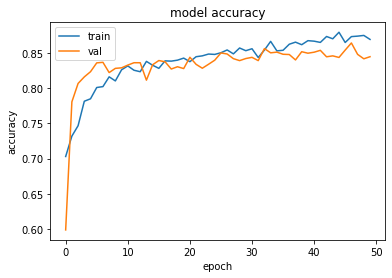

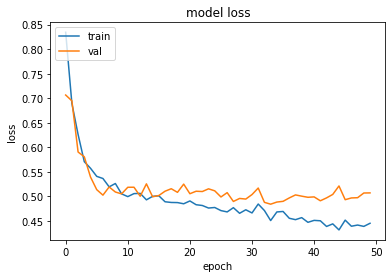

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.49553778767585754 , AUC = 0.841493546962738 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8449756370317117
test 0.8414935260463717

-----------------------------------------------------------------


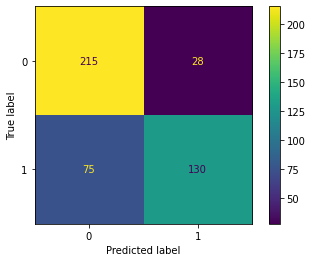

In [37]:
# Create directory to save models
import matplotlib.pyplot as plt

rt_sv_dir = '/content/models/50epoch'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  #optimizer = keras.optimizers.Adam(lr=0.01)

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  
  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

0
Num_samples: 448
acc:  0.7700892857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


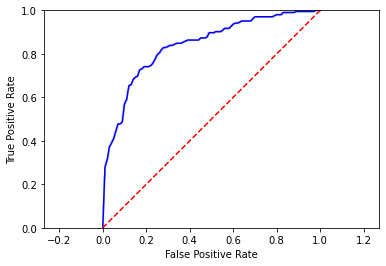

In [38]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/50epoch/0/050--0.507--0.445.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)


  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(224,224))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

## 100 epoch

In [ ]:
# Create directory to save models
import matplotlib.pyplot as plt

rt_sv_dir = '/content/models/100epoch'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  #optimizer = keras.optimizers.Adam(lr=0.01)

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  

  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=100,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

rm: cannot remove '/content/models/100epoch': No such file or directory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100


In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/030--0.459--0.483.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()